# Solução Teste Técnico NLP 

- Autor: Edilson Santos
- Linkedin: https://www.linkedin.com/in/edilsonsantosjr/

# 1.0 QUESTÃO 1 - Com esse dataset tão variado que tipo de soluções acha possível implementar?

Podemos implementar uma variedade de soluções com esses tweets, vamos analisar os datasets:

- **Tweets com Tema**: Coletados usando cerca de 100 termos políticos juntamente com emoticons positivos e negativos. Contém cerca de 60 mil tweets.
    - Nesse dataset podemos analisar a popularidade de figuras públicas e políticas, como presidente, governadores, deputados e senadores e como está o sentimento geral sobre a eleição(quem está mais favorável para ganhar).
    - Questões em debate. Quais tópicos políticos são mais discutidos? Isso pode fornecer insights sobre as preocupações do público.

- **Tweets sem tema**: Coletados usando apenas emoticons positivos e negativos. Contém cerca de 780 mil tweets.
    - Aqui podemos fazer análises mais abrangentes, como: analise de sentimento automática de tweets entre negativo, neutro e positivo.
    - Extração de informações: Extratir informações relevantes, como menções a produtos, empresas, locais, entre outros.
- **Tweets Neutros com hashtags**: Coletados usando hashtags. Contém cerca de 15 mil tweets.
    - Identificação de tópicos populares: Analisar os tweets para identificar tópicos ou temas populares em discussões através das hashtags.
- **Tweets Neutro de contas Públicas**: Coletados diretamente de contas populares de notícias. Contém cerca de 35 mil tweets.
    - Como os tweets são de contas populares de noticias, como Globo, CNN, etc, podemos utilizar esses dados para verificar quais notícias estão em alta no momento e quais acontecimentos estão sendo discutidos.
    - Identificação de Fake News: Podemos tentar identificar quais notícias são falsas para ajudar no combate a desinformação.

# 2.0 QUESTÃO 2 - Imagine que tenha que desenvolver dois serviços:
- Identificar se o tweet se refere a um produto.
- Identificar se ele cita alguma vaga de emprego.
- Escolha um dos projetos e mapeie os requisitos e as necessidades para o desenvolvimento,
que tarefas teria que fazer, quais técnicas usaria e porque.

Eu provalvemente escolheria identificar se o tweet cita alguma vaga de emprego. Seguem os passos que eu faria para executar esse serviço:

1. **Requisitos**: Base de dados com um conjunto de dados que contenha tweets rotulados indicando se mencionam ou não vagas de emprego. Esses rótulos seriam binários, onde 0 representa a ausência de menção a vagas e 1 representa a menção de vagas.
2. **Coleta de dados**: Caso não exista essa base de dados o ideal seria coletá-los através de ferramentas de webscrapping, como Selenium e BeatifoulSoup e rolulá-los.
3. **Verificação de Qualidade**: Assegurar que não exista valores ausentes, como textos em branco ou NaNs, que possam prejudicar a análise.
4. **Processamento dos dados e Limpeza**: Retirar todo tipo de ruído dos textos, como links, emoticons, pontuação, stopwords, conversão de letras maiúsculas em minúsculas e aplicar técnicas como Lemmatization ou Steamming para reduzir palavras à sua forma base.
5. **Feature Engineering**: Pode ser feito a categorização das vagas, por exemplo: vagas por área(TI, Engenharia, RH, etc). Podemos procurar vagas por cargo: estágio, júnior, sênior, etc.
6. **Análise Exploratória**: Fazer algumas análises para entender melhor os dados, como: Quais vagas mais aparecem e para qual área?
7. **Machine Learning**: Criar um modelo de classificação binária que encontrará os tweets com e sem vagas de emprego. Podemos usar modelos mais simples como Naive Bayes e SVM(Support Vector Machines) ou modelos pré-treinados avançados como o BERT ou GPT.
8. **Avaliação do Modelo**: Utilizaria métricas como Recall, Precision e F1-Score. Focaria em maximizar a Recall para que o modelo consiga capturar o máximo de vagas de emprego.
9. **Deploy do Modelo**: Realizaria a implantação do modelo em uma infraestrutura de nuvem, utilizando serviços e recursos disponíveis em plataformas como Amazon Web Services (AWS) ou Google Cloud Platform (GCP). A implementação do modelo como uma API permitiria a realização de previsões em tempo real, fornecendo uma interface para a interação com o modelo treinado.
10. **Manutenção do Modelo**: Retreinar o modelo a cada mês para capturarmos tendências temporais e deixá-lo mais preciso com uma base de dados maior.

### Questão 3 e 4 são feitas durante o notebook utilizando a mesma base de dados.

## Importações

In [240]:
import pandas                            as pd
import numpy                             as np
import seaborn                           as sns
import nltk
import re
import matplotlib.pyplot                 as plt
import tensorflow                        as tf
from nltk.corpus                         import stopwords
from nltk.stem                           import WordNetLemmatizer

from collections                         import Counter
from wordcloud                           import WordCloud

from unidecode                           import unidecode
from tqdm.notebook                       import tqdm
                       
from sklearn.model_selection             import train_test_split
from sklearn.metrics                     import (accuracy_score, 
                                                 precision_score, 
                                                 recall_score, 
                                                 f1_score, 
                                                 confusion_matrix, 
                                                 roc_curve, 
                                                 auc, 
                                                 precision_recall_curve)

from sklearn.feature_extraction.text     import TfidfVectorizer
from sklearn.naive_bayes                 import MultinomialNB

from keras.utils                         import to_categorical
from keras.models                        import Sequential
from keras.layers                        import Embedding, LSTM, Dense
from keras.preprocessing.text            import Tokenizer
from keras.preprocessing.sequence        import pad_sequences


pd.set_option('display.max_colwidth', None)

nltk.download('stopwords')
nltk.download('wordnet')

sns.set_style('darkgrid')
plt.style.use('ggplot')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/edilson07/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/edilson07/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Carregar os dados

Vamos começar carregando os dados com tema e sem tema e unindo-os para conseguir o máximo de dados possível. Deixei explícito a divisão por tema caso seja interessante fazer alguma análise política.

In [241]:
PATH = '/home/edilson07/projects/neuralmed_case/datasets/'

def carregar_dados(path):
    no_theme = pd.read_csv(path + 'NoThemeTweets.csv')
    no_theme['tipo'] = 'sem_tema '

    with_theme = pd.read_csv(path + 'TweetsWithTheme.csv')
    with_theme['tipo'] = 'com_tema '

    df = pd.concat([no_theme, with_theme])
    df['tipo'] = df['tipo'] + df['sentiment']

    df = df.drop_duplicates(keep='first')

    return df


df_tweets = carregar_dados(PATH)

In [242]:
df_tweets.head()

,id,tweet_text,tweet_date,sentiment,query_used,tipo
0,1031761728445530112,@Tixaa23 14 para eu ir :),Tue Aug 21 04:35:39 +0000 2018,Positivo,:),sem_tema Positivo
1,1031761040462278656,@drexalvarez O meu like eu já dei na época :),Tue Aug 21 04:32:55 +0000 2018,Positivo,:),sem_tema Positivo
2,1031760962372689920,Eu só queria conseguir comer alguma coisa pra poder dormir :),Tue Aug 21 04:32:37 +0000 2018,Positivo,:),sem_tema Positivo
3,1031760948250456066,:D que lindo dia !,Tue Aug 21 04:32:33 +0000 2018,Positivo,:),sem_tema Positivo
4,1031760895985246208,"@Primo_Resmungao Pq da pr jeito!!é uma ""oferta"", ha q aproveitar. :P",Tue Aug 21 04:32:21 +0000 2018,Positivo,:),sem_tema Positivo


## Descrição dos dados

In [243]:
df_tweets.shape

(847405, 6)

In [244]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 847405 entries, 0 to 61590
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          847405 non-null  int64 
 1   tweet_text  847405 non-null  object
 2   tweet_date  847405 non-null  object
 3   sentiment   847405 non-null  object
 4   query_used  847405 non-null  object
 5   tipo        847405 non-null  object
dtypes: int64(1), object(5)
memory usage: 45.3+ MB


In [245]:
df_tweets['sentiment'].value_counts(normalize=True)

sentiment
Negativo    0.650874
Positivo    0.349126
Name: proportion, dtype: float64

Temos um dataset desbalanceado com 65% da classe negativa e 35% da classe positiva.

Text(0, 0.5, 'Proporção')

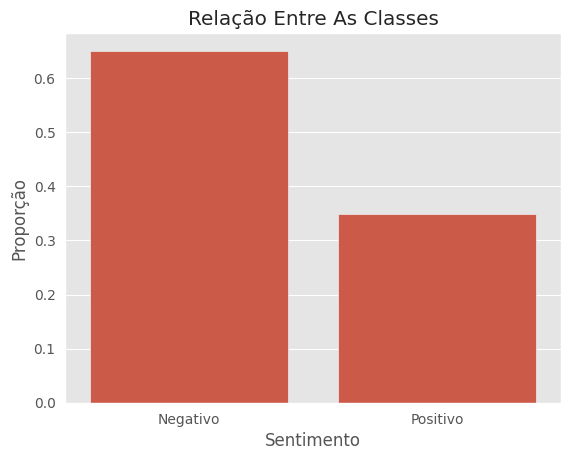

In [246]:
sns.barplot(df_tweets['sentiment'].value_counts(normalize=True))
plt.title("Relação Entre As Classes")
plt.xlabel("Sentimento")
plt.ylabel("Proporção")

## Limpeza e Processamento dos Textos

In [247]:
df_tweets = df_tweets.drop(['id','tweet_date','query_used'], axis=1)

Aqui vamos fazer algumas limpezas no texto, como:

- Remover URLs
- Remover menções(@)
- Remover hashtags(#)
- Remover Pontuações, Caracteres especiais e Acentuação

Também vamos utilizar algumas técnicas de NLP como:
- Remoçao de stopwords: são palavras conectores que não adicionam nenhum sentido ao texto, exemplo: ele, ela, a, os, eles, etc.
- Normalização: Para o modelo há diferença entre palavras maiúsculas e minúsculas, exemplo: Tweet e tweet tem o mesmo significado mas seriam 2 tokens diferentes para o modelo, então vamos transformar tudo em minúsculas.
- Lemmatization: transformar palavras flexionadas ou derivadas em sua forma base, exemplo:
    - Correndo -> correr
    - Cães -> cão
    - Melhores -> melhor 

In [248]:
def clean_tweet(tweet):
    #Stopwords não incluídas no NLTK
    custom_stopwords = ["d", "q", "p", 'pra']
    
    # Remova URLs
    tweet = re.sub(r'http\S+', '', tweet)
    
    # Remova menções a usuários (@usuários)
    tweet = re.sub(r'@\w+', '', tweet)
    
    # Remova hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    
    # Remova pontuação e caracteres especiais
    tweet = re.sub(r'[^\w\s]', '', tweet)

    # Remova acentuação
    tweet = unidecode(tweet)
    
    # Tokenização (dividir o texto em palavras)
    tokens = tweet.split()
    
    # Remoção de stopwords
    stop_words = set(stopwords.words('portuguese') + custom_stopwords)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Normalização
    tokens = [word.lower() for word in tokens]
    
    # Lematização
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Reunir as palavras novamente em um único texto
    cleaned_tweet = ' '.join(tokens)
    
    return cleaned_tweet
    

df_tweets['cleaned_tweet_text'] = df_tweets['tweet_text'].apply(clean_tweet)

Vamos remover tweets com poucas palavras

In [249]:
df_tweets = df_tweets[df_tweets['cleaned_tweet_text'].apply(lambda x: len(x.split()) > 1)]

In [250]:
df_tweets.shape

(790342, 4)

## EDA(Análise Exploratória)

Podemos começar analisando quais palavras mais aparecem no tweets.

In [251]:
# Juntar todos os tweets
texts = ''.join(df_tweets['cleaned_tweet_text'])
words = texts.split()

# Contar quantidade de cada palavra 
word_count = Counter(words)
df_words = pd.DataFrame(word_count.items(), columns=['word','count'])

In [252]:
df_words.sort_values(by='count', ascending=False).head()

,word,count
65,nao,158375
126,so,48823
50,to,45292
458,ta,41739
256,vai,34367


Text(0, 0.5, 'Contagem')

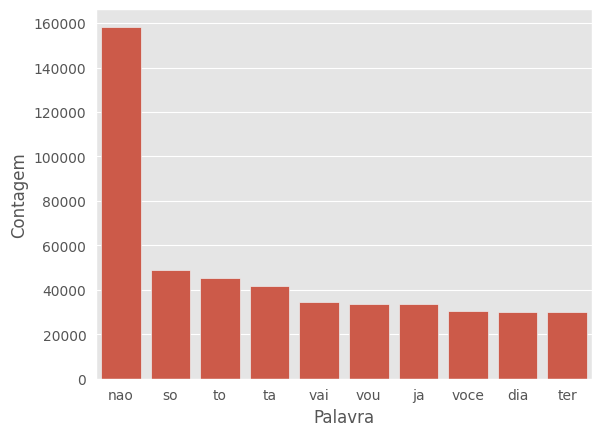

In [253]:
top_10 = df_words.sort_values(by='count', ascending=False).iloc[:10]
sns.barplot(top_10, x='word', y='count')
plt.xlabel("Palavra")
plt.ylabel("Contagem")

Interessante! A palavra que mais aparece é "não". talvez esse seja o motivo de termos mais tweets com sentimento negativo do que positivo, já que "não" geralmente é usada em um contexto negativo.

## WordCloud

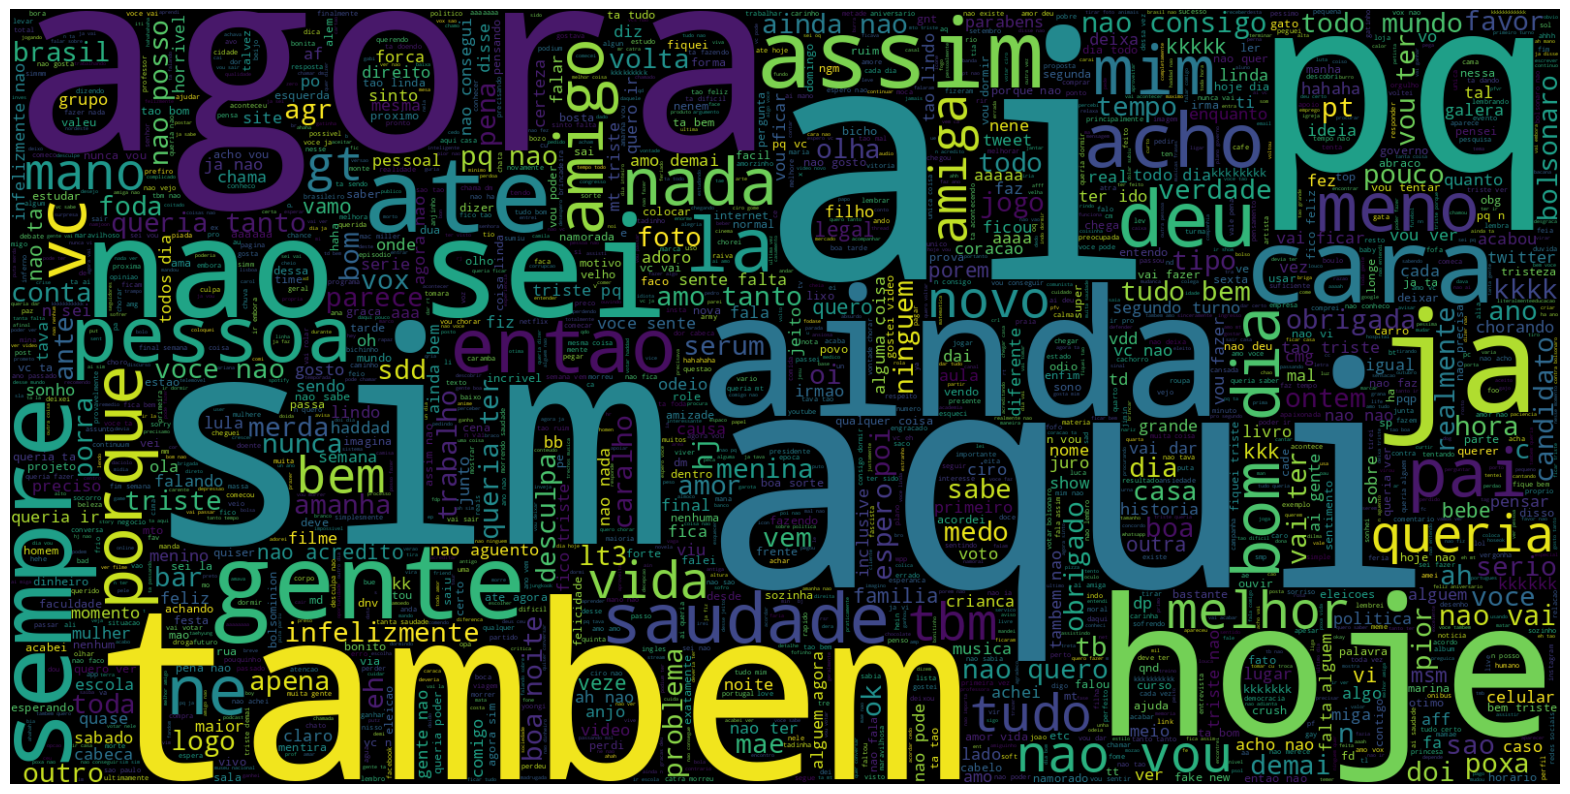

In [254]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words=2000, width=1600, height=800).generate(" ".join(df_tweets['cleaned_tweet_text']))
plt.imshow(wc , interpolation = 'bilinear')
plt.axis("off")  
plt.gca().set_frame_on(False)  
plt.show()

No wordcloud não temos uma contagem exata das palavras mas podemos ter uma noção da frequência das mais usadas e que indicam algum tipo de sentimento: temos o "sim", "nao", "poxa", "amo tanto", "nao consigo", etc.

# 3.0 QUESTÃO 3 - É possível desenvolver alguma parte do item acima com os dados que você tem?

Sim, vamos começar encontrando tweets que mencionam vagas de empregos, procurando pelas palavras abaixo nos tweets.

Vamos focar na métrica Recall para tentarmos capturar o máximo de vagas de emprego possíveis.

## Coleta de Dados

In [255]:
# Função para encontrar Vagas de Emprego
def mentions_job_vacancy(tweet):
    palavras_emprego = ["vaga", "vagas", "curriculo", "curriculos"]
    
    # Use expressões regulares para encontrar palavras completas
    padrao = r'\b(?:' + '|'.join(palavras_emprego) + r')\b'
    
    if re.search(padrao, tweet, re.IGNORECASE):
        return True
    
    return False

# Nova coluna no DataFrame indicando se o tweet menciona uma vaga de emprego
df_tweets['mencao_empregos'] = df_tweets['cleaned_tweet_text'].apply(mentions_job_vacancy)

In [256]:
df_tweets['mencao_empregos'].value_counts()

mencao_empregos
False    789535
True        807
Name: count, dtype: int64

Conseguimos encontrar alguns tweets com vagas de emprego! Porém a quantidade ainda é pequena. Vamos tentar trabalhar com esses dados.

In [257]:
df_tweets.loc[df_tweets['mencao_empregos'],:].head()

,tweet_text,sentiment,tipo,cleaned_tweet_text,mencao_empregos
3016,"Se você encontrasse um gênio da lâmpada, quais seriam seus 3 desejos? — vaga na federal, uma fazenda para os meus pais e um amor de verdade para mim :) https://t.co/3XBZzPenTr",Positivo,sem_tema Positivo,voce encontrasse genio lampada quais 3 desejos vaga federal fazenda pais amor verdade mim,True
3971,@VsfPedroso @CPGFAC tem mais uma vaga ae??? :D,Positivo,sem_tema Positivo,vaga ae,True
4680,Até o dia 23 você pode se candidatar para trabalhar na região do Pimentas. Confira os requisitos das vagas e vá até uma das unidades do CIET :) https://t.co/VyIaudjIW9,Positivo,sem_tema Positivo,ate dia 23 voce pode candidatar trabalhar regiao pimenta confira requisitos vagas va ate unidades ciet,True
5511,"Acho incrível essas vagas de estágio que só contratam estagiários com experiência, porém pra tu ter experiência tu precisa de um estágio :)))))",Positivo,sem_tema Positivo,acho incrivel vagas estagio so contratam estagiarios experiencia porem ter experiencia precisa estagio,True
5572,Dia 19. Tenho vagas disponíveis pra Mentoria Online de Pintura Digital em Setembro. Me procura se tiver interesse :) #L30NI #painting #illustration #digitalart #heman https://t.co/4rdewmLlqN,Positivo,sem_tema Positivo,dia 19 vagas disponiveis mentoria online pintura digital setembro procura interesse,True


## Limpeza Pré-Processamento

Comos os dados já estão limpos e processados, precisamos apenas criar um novo dataframe com exemplos sem empregos e com emprego

In [258]:
# 1000 exemplos de tweets que não mencionam vagas de emprego
df_semvagas = df_tweets.loc[df_tweets['mencao_empregos'] == False,:][:1000]

df_vagas = df_tweets.loc[df_tweets['mencao_empregos'] == True]

# Juntar os dois datasets em um só
df_train_empregos = pd.concat([df_semvagas, df_vagas])

Vamos dar uma olhada como ficou o dataset:

In [259]:
df_train_empregos.sample(5)

,tweet_text,sentiment,tipo,cleaned_tweet_text,mencao_empregos
734378,"Analista de Data &amp; Insights Pleno Valoriza um ambiente colaborativo, transparente e de muito aprendizado? Então essa vaga é pra você :) Buscamos por alguém apaixono por análises e geração de insights para trabalhar... https://t.co/qDPQzmHvXd",Positivo,sem_tema Positivo,analista data amp insight pleno valoriza ambiente colaborativo transparente aprendizado entao vaga voce buscamos alguem apaixono analises geracao insight trabalhar,True
981,"Ainda bem que saiu de perto daquele falso, oportunista, vc merece mais :) — nao ousem falar mal dele https://t.co/cDg0Vs2pLg",Positivo,sem_tema Positivo,ainda bem saiu perto daquele falso oportunista vc merece nao ousem falar mal,False
14694,"@mi_frasson Temos vagas no Nubank! Dá uma olhada em https://t.co/hz3KVjcsp9, especificamente UI Engineer para frontend web. :)",Positivo,sem_tema Positivo,vagas nubank olhada especificamente ui engineer frontend web,True
705687,"@giovannabreve Não conheço, mas vou divulgar a vaga, talvez apareça alguém :)",Positivo,sem_tema Positivo,nao conheco vou divulgar vaga talvez apareca alguem,True
850,@fullmigasamurai em itens: 1. fun fact do gado 2. manter os migo do orkut foi um elogio ss :),Positivo,sem_tema Positivo,itens 1 fun fact gado 2 manter migo orkut elogio s,False


In [272]:
df_train_empregos.shape

(1807, 6)

## Feature Engineering

Podemos criar features que mencionam vagas de estágio, vamos procurar pela palavra 'estágio' e criar uma nova coluna

In [260]:
#Procurar vagas de estágio
def estagio(tweet):
    palavra = 'estagio'

    if re.search(palavra, tweet):
        return True
    else:
        return False
df_train_empregos['vaga_estagio'] = df_train_empregos['cleaned_tweet_text'].apply(estagio)

## EDA

Vamos entender a proporção de vagas para estagiários em relação ao total

Percentual de vagas para estágio: vaga_estagio
False    0.959108
True     0.040892
Name: proportion, dtype: float64


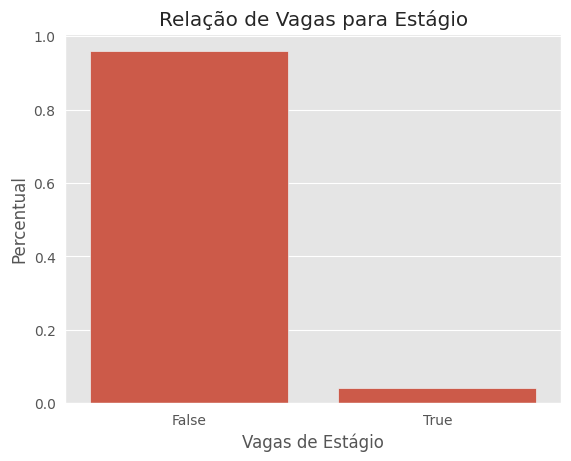

In [261]:
proporcao_estagio = (df_train_empregos.loc[df_train_empregos['mencao_empregos'] == True]
['vaga_estagio'].value_counts(normalize=True))

sns.barplot(proporcao_estagio)
plt.xlabel("Vagas de Estágio")
plt.ylabel("Percentual")
plt.title("Relação de Vagas para Estágio")

print(f'Percentual de vagas para estágio: {proporcao_estagio}')

Podemos ver que são poucas vagas para estágio, cerca de 4% apenas.

## Machine Learning

Vou utilizar um modelo simples como Multinomial Naive Bayes para fazer as previsões: ele modela a probabilidade de ocorrência das palavras nos tweets.

Vamos fazer a vetorização para o MultinomialNB utilizando a abordagem **TF-IDF(Term Frequency-Inverse Document Frequency)**. Ela converte valores de texto em vetores númericos. Dessa forma o Modelo pode fazer o treinamento.

In [262]:
# Vetorização
vectorizer = TfidfVectorizer()
X_empregos = vectorizer.fit_transform(df_train_empregos['cleaned_tweet_text'])

# Split em treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X_empregos, df_train_empregos['mencao_empregos'], test_size=0.2, stratify=df_train_empregos['mencao_empregos'], random_state=42)

In [263]:
# Treinamento do modelo Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Previsões
y_pred = nb_model.predict(X_test)

## Avaliação do Modelo

Text(0.5, 1.0, 'Confusion Matrix')

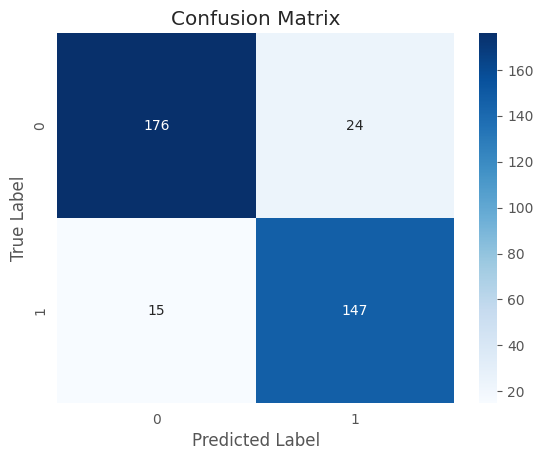

In [264]:
# Matriz de Confusão
cmatrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [265]:
# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.892
Recall: 0.907
Precision: 0.860
F1 Score: 0.883


Por mais que o base de dados fosse pequena o modelo conseguiu um desempenho interessante! Cerca de 90% de recall, ou seja, dos 162 tweets que continham vagas de emprego, ele consegui acertar 147!

# 4.0 QUESTÃO 4 - Faça um modelo de análise de sentimentos dos tweets. 

Vamos utilizar base de dados já limpa e o mesmo modelo para fins de simplicidade com o MultinomialNB. Porém aqui vamos focar na métrica F1-Score, já que não temos preferência em acertar mais a classe positiva ou negativa, ou seja, as duas classes são igualmente importantes para o modelo.

In [276]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_tweets['cleaned_tweet_text'])

In [277]:
X_train, X_test, y_train, y_test = train_test_split(X, df_tweets['sentiment'], test_size=0.2, stratify=df_tweets['tipo'], random_state=42)

In [278]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

MultinomialNB()

In [279]:
# Previsões
y_pred = nb_model.predict(X_test)

In [280]:
# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, pos_label="Positivo")
recall = recall_score(y_test, y_pred, pos_label="Positivo")
precision = precision_score(y_test, y_pred, pos_label="Positivo")

print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.771
Recall: 0.451
Precision: 0.809
F1 Score: 0.579


Text(0.5, 1.0, 'Matriz de Confusão')

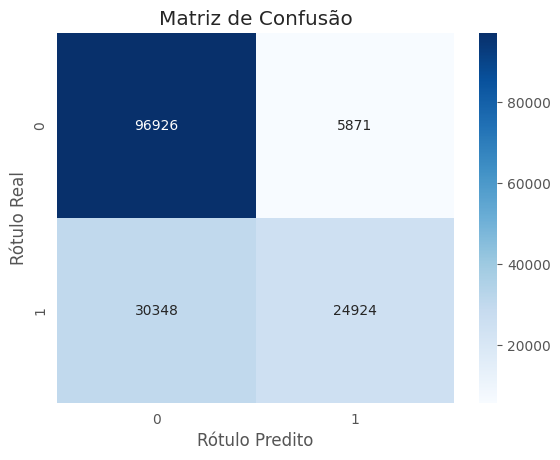

In [281]:
# Matriz de Confusão
cmatrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Real')
plt.title('Matriz de Confusão')

Podemos ver que nosso modelo está errando muito na classe positiva, classificando muito dos tweets originalmente com sentimento positivo como negativos(falsos negativos). É de se esperar pois nosso modelo é muito simples.

Podemos tentar aplicar um modelo mais complexo, como uma rede neural.

## Redes Neurais

Vamos começar definindo o vocabulário, o tamanho da sequência de palavras e camada de embedding de entrada da nossa rede neural

In [282]:
# Parâmetros
max_words = 10000  # Número máximo de palavras a serem consideradas no vocabulário
max_sequence_length = 100  # Tamanho máximo da sequência de entrada
embedding_dim = 100  # Dimensão do espaço de incorporação
output_dim = 1  # Número de unidades de saída

Agora vamos fazer a tokenização, que transforma cada palavra em um token único para nosso modelo. Também vamos transformar esses tokens em sequências e os tweets que sejam menores que 100(nosso tamanho máximo da sequência) serão preenchidos com 0 através da técnica de padding.

In [283]:
# Tokenização
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_tweets['cleaned_tweet_text'])
sequences = tokenizer.texts_to_sequences(df_tweets['cleaned_tweet_text'])

In [284]:
# Padding
data = pad_sequences(sequences, maxlen=max_sequence_length)

Por fim vamos transformar nossos dados em treino, teste e validação e treinar nosso modelo.

In [285]:
# Rótulos
labels = df_tweets['sentiment'].apply(lambda x: 1 if x == 'Positivo' else 0)

In [286]:
# Divisão em treinamento, validação e teste
train_data, X_test, train_labels, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

Definição do modelo: por simplicidade decidi apenas usar uma camada de **LSTM(Long Short-Term Memory)**: A camada LSTM possui células de memória que podem armazenar informações e decidir o que deve ser esquecido ou lembrado. Essas células permitem que a rede lide efetivamente com sequências de dados de diferentes tamanhos como textos.

In [168]:
# Construção do modelo
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(64))
model.add(Dense(output_dim, activation='sigmoid'))  

Early stopping para evitar overfitting: caso a loss da validação não melhore por 3 épocas o treinamento é interrompido.

In [169]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [170]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [171]:
# Treinamento
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/25
15807/15807 [==============================] - 392s 25ms/step - loss: 0.4406 - accuracy: 0.7888 - val_loss: 0.4247 - val_accuracy: 0.7972
Epoch 2/25
15807/15807 [==============================] - 351s 22ms/step - loss: 0.4016 - accuracy: 0.8128 - val_loss: 0.4190 - val_accuracy: 0.8021
Epoch 3/25
15807/15807 [==============================] - 336s 21ms/step - loss: 0.3785 - accuracy: 0.8253 - val_loss: 0.4209 - val_accuracy: 0.8024
Epoch 4/25
15807/15807 [==============================] - 355s 22ms/step - loss: 0.3562 - accuracy: 0.8382 - val_loss: 0.4334 - val_accuracy: 0.7999
Epoch 5/25
15807/15807 [==============================] - 302s 19ms/step - loss: 0.3318 - accuracy: 0.8512 - val_loss: 0.4476 - val_accuracy: 0.7970
Epoch 5: early stopping


Agora vamos analisar as métricas

In [287]:
# Previsões
y_pred_probs = model.predict(X_test)

4940/4940 [==============================] - 41s 8ms/step


In [288]:
y_pred_int = (y_pred_lstm > 0.5).astype(int)

In [289]:
# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred_int)
f1 = f1_score(y_test, y_pred_int)
recall = recall_score(y_test, y_pred_int)
precision = precision_score(y_test, y_pred_int)

print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.805
Recall: 0.655
Precision: 0.753
F1 Score: 0.701


Text(0.5, 1.0, 'Matriz de Confusão')

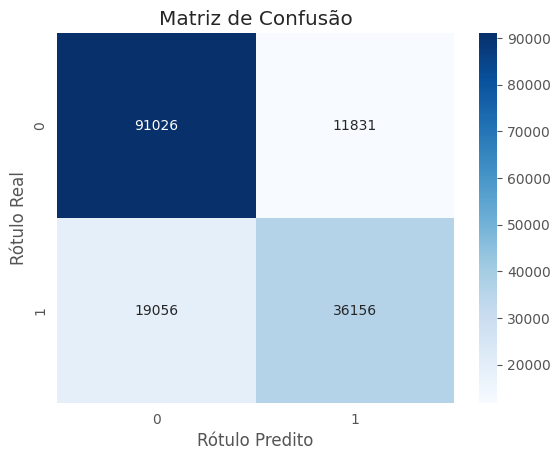

In [290]:
# Matriz de Confusão
cmatrix = confusion_matrix(y_test, y_pred_int)
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Real')
plt.title('Matriz de Confusão')

Agora sim! Conseguimos aumentar o F1 Score de 58%(MultinomialNB) para 70%! Agora conseguimos acertar muito mais tweets com o sentimento positivo do que antes!

Outra técnica que podemos utilizar é o mudar o threshold. Plotando a Curva ROC e a Precision-Recall podemos observar melhor qual seria um threshold interessante.

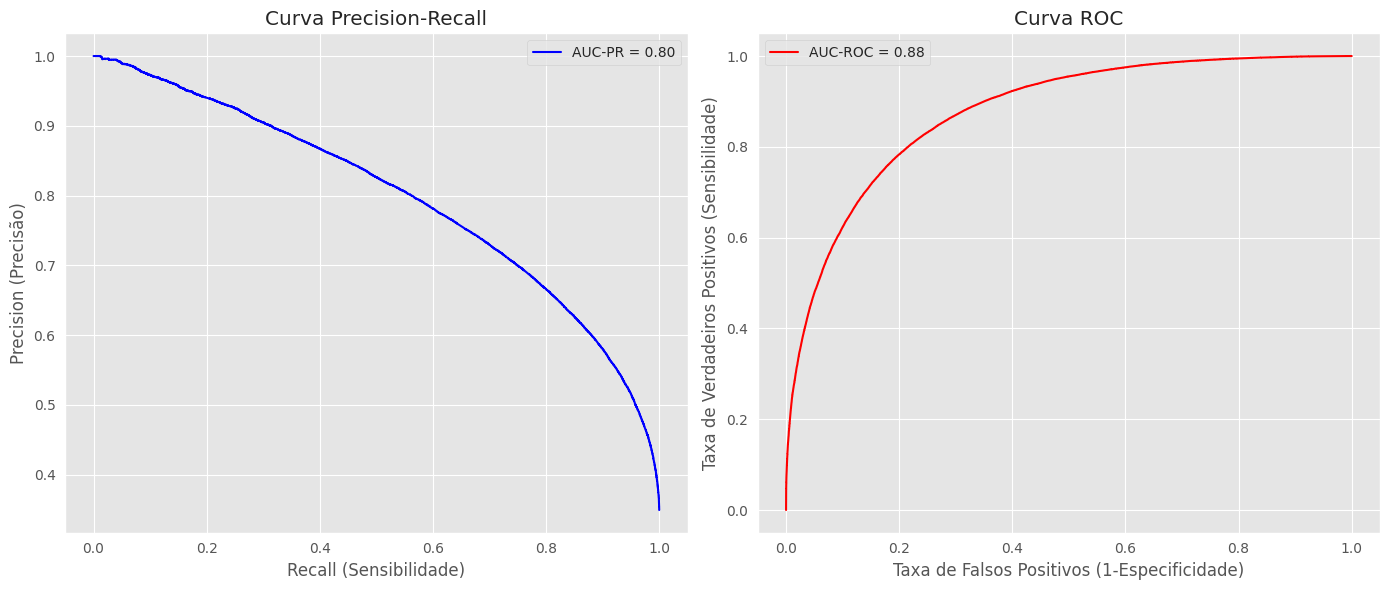

In [291]:
# Curva Precision-Recall
precision, recall, thresholds_pcr = precision_recall_curve(y_test, y_pred_probs)
auc_pr = auc(recall, precision)

# Curva ROC 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
auc_roc = auc(fpr, tpr)

# Plotando as curvas
plt.figure(figsize=(14, 6))

# Curva Precision-Recall
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='blue', label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall (Sensibilidade)')
plt.ylabel('Precision (Precisão)')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True)

# Curva ROC
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='red', label=f'AUC-ROC = {auc_roc:.2f}')
plt.xlabel('Taxa de Falsos Positivos (1-Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Através dessas curvas podemos calcular o F1 Score para cada threshold e encontrar onde ele alcança seu máximo valor, e então usar esse threshold.

In [292]:
# Calculando o F1-score para cada threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Threshold que maximiza o F1-score
best_threshold = thresholds_pcr[np.argmax(f1_scores)]

print("Melhor threshold para F1-score máximo:", best_threshold)

Melhor threshold para F1-score máximo: 0.3296461


In [293]:
y_pred_th = (y_pred_probs > best_threshold).astype(int)

Por fim vamos avaliar nosso modelo com o novo Threshold.

In [294]:
# Avaliação do modelo
accuracy = accuracy_score(y_test, y_pred_th)
f1 = f1_score(y_test, y_pred_th)
recall = recall_score(y_test, y_pred_th)
precision = precision_score(y_test, y_pred_th)

print(f"Accuracy: {accuracy:.3f}")
print(f"Recall: {recall:.3f}")
print(f"Precision: {precision:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.791
Recall: 0.798
Precision: 0.667
F1 Score: 0.727


Text(0.5, 1.0, 'Matriz de Confusão')

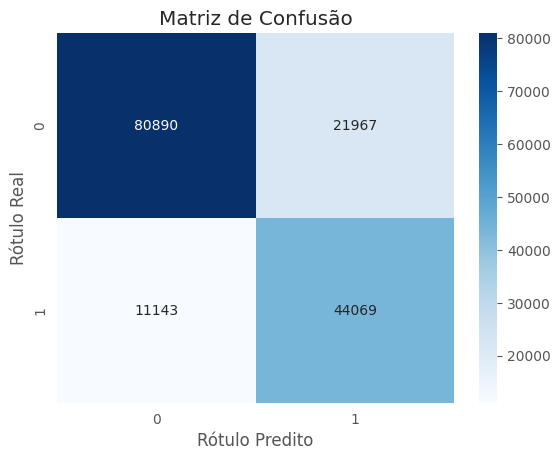

In [295]:
# Matriz de Confusão
cmatrix = confusion_matrix(y_test, y_pred_th)
sns.heatmap(cmatrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Rótulo Predito')
plt.ylabel('Rótulo Real')
plt.title('Matriz de Confusão')

Incrível! Nosso modelo melhorou bastante o recall de 65% para 80%! acabamos perdendo um pouco de precisão mas nosso f1-score chegou ao máximo de 72,7%.

Para finalizar podemos dar uma olhada na nossa distruibuição dos erros do modelo para entender onde ele está errando mais.

In [296]:
# Separar 3 Dataframes: 1 com os valores reais(y_test) outro com predições inteiras(0 e 1)
# e outro com as probabilidades
df_y = pd.DataFrame(y_test).reset_index()
df_pred_classes = pd.DataFrame(y_pred_th, columns=['y_pred'], index=df_y.index)
df_pred_probs = pd.DataFrame(y_pred_probs, columns=['probabilities'], index=df_y.index)

# Separar apenas os indice que há erro na previsão
error_indices = df_y[df_y['sentiment'] != df_pred_classes['y_pred']].index

# Utilizar esse índice que possui os erros e se separar as probalidades que o modelo deu para
# a classe positiva
error_probs = df_pred_probs.loc[error_indices]

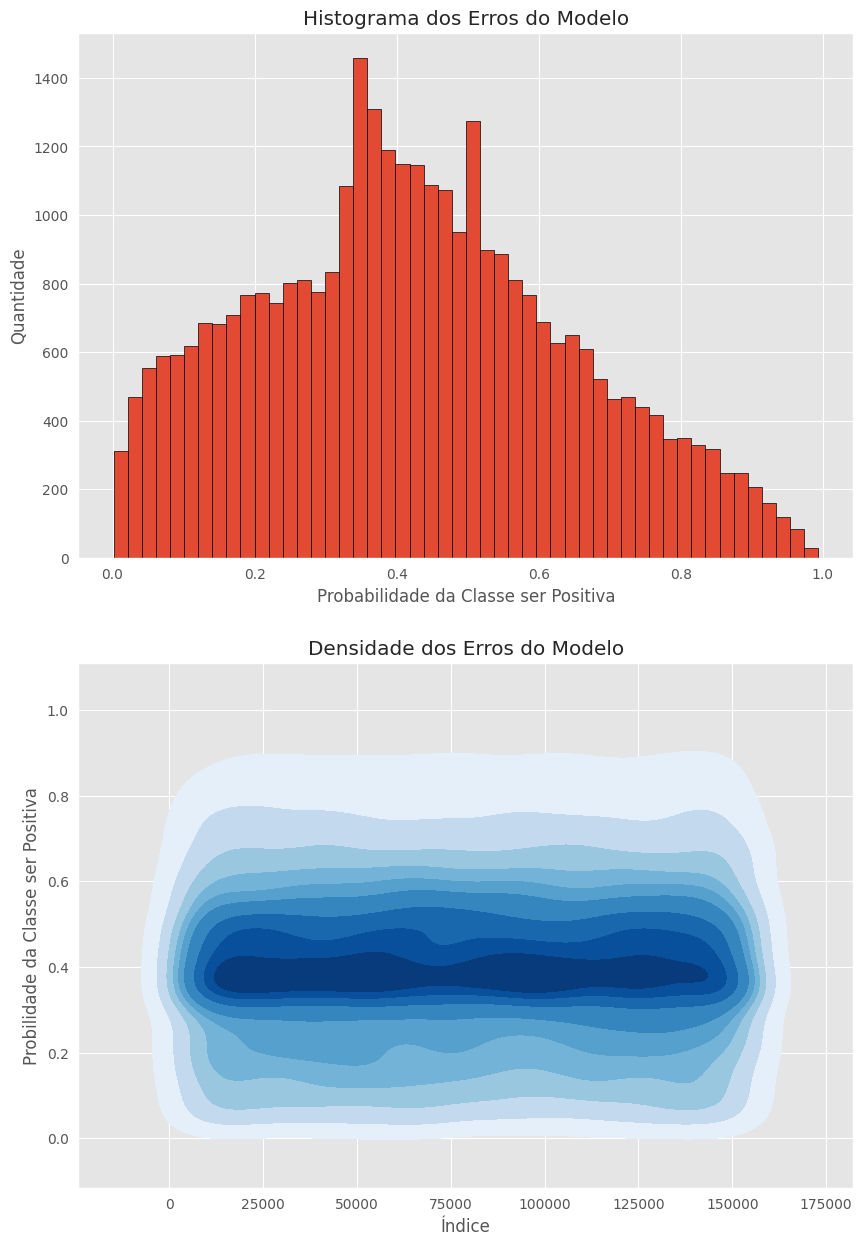

In [298]:

plt.figure(figsize=(10,15))

# Plotar Histograma apenas com os erros e suas respectivas probabilidades
plt.subplot(2,1,1)
plt.hist(error_probs['probabilities'], bins=50, edgecolor='k')
plt.title('Histograma dos Erros do Modelo')
plt.xlabel('Probabilidade da Classe ser Positiva')
plt.ylabel('Quantidade')

# Plotar Densidade apenas com os erros e suas respectivas probabilidades
plt.subplot(2,1,2)
sns.kdeplot(x=error_indices, y=error_probs['probabilities'], cmap='Blues', fill=True)
plt.title('Densidade dos Erros do Modelo')
plt.xlabel('Índice')
plt.ylabel('Probilidade da Classe ser Positiva')
plt.grid(True)

## Conclusão

Pelos gráficos acima podemos ver que a maioria dos erros se encontram nas probabilidades entre 0.3 e 0.5 em média. Uma solução para melhorar nosso modelo seria classificar essas probabilidades como uma terceira classe "Neutro".

Podemos também rotular os dados usados como base de treinamento com 3 classes, "Positivo", "Negativo" e "Neutro". Dessa forma nosso modelo será mais preciso na classificação.

Por fim, ainda podemos tentar diminuir o desbalanceamento das classes inserindo mais tweets da classe minoritária na base de dados.